In [1]:
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1D Gaussian distribution approximation using GAN

In [2]:
# Data distribution --> Gaussian
class DataDistribution:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def sample(self, num_samples):
        samples = np.random.normal(self.mean, self.std, num_samples)
        samples.sort()
        return samples

In [3]:
mean = 1.0
std = 1.5
data = DataDistribution(mean, std)

(array([  1.,   3.,   6.,   7.,  27.,  62., 111., 177., 187., 283., 286.,
        258., 228., 175., 105.,  47.,  26.,   5.,   3.,   3.]),
 array([-4.83485883, -4.2748756 , -3.71489236, -3.15490912, -2.59492589,
        -2.03494265, -1.47495941, -0.91497617, -0.35499294,  0.2049903 ,
         0.76497354,  1.32495677,  1.88494001,  2.44492325,  3.00490648,
         3.56488972,  4.12487296,  4.68485619,  5.24483943,  5.80482267,
         6.3648059 ]),
 <a list of 20 Patch objects>)

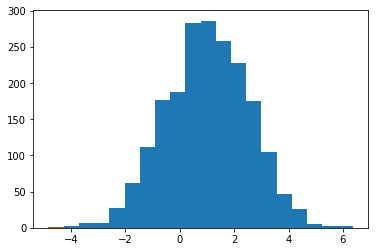

In [4]:
n_bins=20
data_sample = data.sample(2000)
plt.hist(data_sample, n_bins)

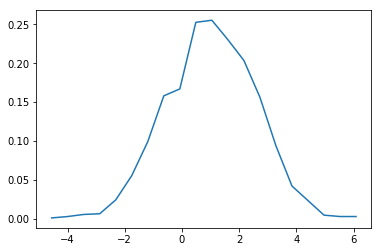

In [5]:
## Different plottling style
prob, bins = np.histogram(data_sample, n_bins, density=True)
xval = (bins[1:] + bins[:-1])/2.
plt.plot(xval, prob)

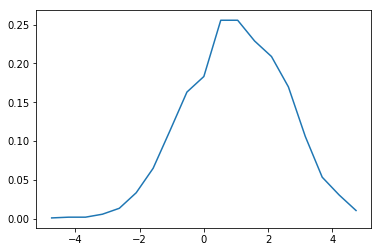

In [6]:
## Global bins defined here
data_range = 5
global_bins = np.linspace(-data_range, data_range, n_bins)
global_xvals = (global_bins[1:] + global_bins[:-1])/2.

prob,bins = np.histogram(data_sample, global_bins, density=True)
plt.plot(global_xvals, prob)

In [7]:
# Noise distribution -> Uniform Distribution
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        offset = np.random.random(num_samples) * 0.01
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        return samples

In [8]:
noise = NoiseDistribution(data_range)
noise_sample = noise.sample(200)

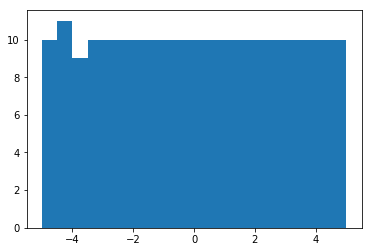

In [9]:
plt.hist(noise_sample, bins=n_bins)
plt.show()

In [10]:
max_points = 10
G = tsp.Spline1D(max_points, x=noise_sample, y=data_sample)
Dl1 = tsp.Spline1D(max_points, x=data_sample, y=noise_sample)
Dl2 = tnn.Sigmoid()

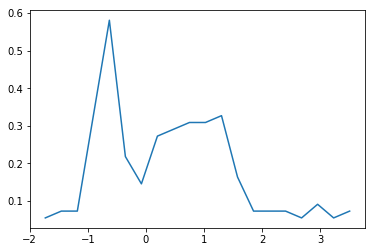

In [11]:
## For Generated values
gen_data = G.forward(noise_sample)
prob, bins = np.histogram(gen_data, n_bins, density=True)
xval = (bins[1:] + bins[:-1])/2.
plt.plot(xval, prob)

In [12]:
## Pretraining the discriminator
learning_rate=0.1

D_pre_losses = []
num_samples_pre = 1000
num_bins_pre = 100
num_epochs_pre = 2000

for epoch in range(num_epochs_pre):
    # Generate samples
    d = data.sample(num_samples_pre)
    histc, edges = np.histogram(d, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)
#     x_ = edges[1:]
    x_ = (edges[1:]+edges[:-1])/2
    y_ = y_.reshape(-1,1)

    # Train model
    a1d = Dl1.forward(x_)
    a2d = Dl2.forward(a1d.reshape(-1,1))
    D_dy = tnn.CrossEntropyBinary.del_loss(a2d, y_)
    D_loss = tnn.CrossEntropyBinary.loss(a2d, y_)
    da1d = Dl2.backward(D_dy).reshape(-1)
    dx_d = Dl1.backward(da1d)

    Dl1.update(learning_rate)
    
    # Save loss values for plot
    D_pre_losses.append(D_loss)

    if epoch % 100 == 0:
        Dl1._maintain_good_spline_()
        print(epoch, D_loss)

0 0.8673702122790989
100 0.6170307020499652
200 0.6094075435700315
300 0.6339925422052601
400 0.5433616287333914
500 0.5641748343438323
600 0.5209879890941376
700 0.501613126862809
800 0.6433909229437925
900 0.5626273929499372
1000 0.5497229762755336
1100 0.4839231326977331
1200 0.4944534617738664
1300 0.5448584142620111
1400 0.496378855156133
1500 0.5126912393372202
1600 0.47861156604134547
1700 0.50482232972285
1800 0.45900740239980864
1900 0.5081538113442012


In [13]:
# Optimizers
learning_rate=0.05
D_losses = []
G_losses = []

In [14]:
batch_size = 150
num_epochs = 5000
num_samples = 10000

0 1.9599340639392382 0.8552093139382354
100 1.955192280387143 0.6292018612377748
200 1.8907324650895423 0.5597204891486327
300 1.7428274727747677 0.5717867686393255
400 1.5973094380947574 0.5945835433306028
500 1.5737088698306065 0.6065773462602286
600 1.3766316427448422 0.6326273612841502
700 1.3580698515217307 0.648129106582011
800 1.3368628482274172 0.6640993396304279
900 1.3245393369104304 0.6737485921676978
1000 1.3361814865045085 0.6771660269038242
1100 1.3598149467470875 0.6760758867873377
1200 1.3559988874437452 0.67796403588808
1300 1.3551956553186186 0.6826937955626294
1400 1.3579848483053014 0.68118199497507
1500 1.3657109881560565 0.6857377957950391
1600 1.3835852772624262 0.6881635421005007
1700 1.3715020228602182 0.6887557438694512
1800 1.3645240619606556 0.6884521106811867
1900 1.381808409187607 0.6895216481610928
2000 1.3723175133291101 0.6869307127030211
2100 1.3780731620965194 0.6830189565002098
2200 1.3974481767300917 0.6776080933821079
2300 1.3926194006007253 0.6787

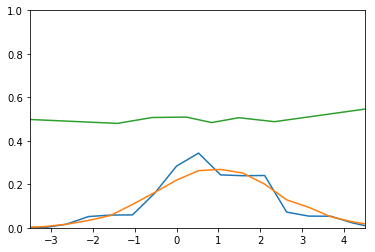

In [15]:
y_real_ = np.ones([batch_size, 1])
y_fake_ = np.zeros([batch_size, 1])

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(num_epochs):
    
    # Get Real samples
    x_ = data.sample(batch_size)
    
    # Train discriminator with real data
    a1d = Dl1.forward(x_)
    a2d = Dl2.forward(a1d.reshape(-1,1))
    D_dy = tnn.CrossEntropyBinary.del_loss(a2d, y_real_)
    D_real_loss = tnn.CrossEntropyBinary.loss(a2d, y_real_)
    da1d = Dl2.backward(D_dy).reshape(-1)
    dx_d = Dl1.backward(da1d)
    Dl1dX = Dl1.del_X.copy()
    Dl1dY = Dl1.del_Y.copy()
#     D_real_output = D(x_)
#     D_real_loss = loss_func(D_real_output, y_real_)

    # Generate samples
    z_ = noise.sample(batch_size)
    z_ = G.forward(z_)
    
    # Train discriminator with fake data
    a1d = Dl1.forward(z_)
    a2d = Dl2.forward(a1d.reshape(-1,1))
    D_dy = tnn.CrossEntropyBinary.del_loss(a2d, y_fake_)
    D_fake_loss = tnn.CrossEntropyBinary.loss(a2d, y_fake_)
    da1d = Dl2.backward(D_dy).reshape(-1)
    dx_d = Dl1.backward(da1d)
    
    Dl1.del_X += Dl1dX
    Dl1.del_Y += Dl1dY
#     D_fake_output = D(z_)
#     D_fake_loss = loss_func(D_fake_output, y_fake_)

    # Back propagation
    Dl1.update(learning_rate)
    D_loss = D_fake_loss + D_real_loss

    # Train generator
    z_ = noise.sample(batch_size)
    z_ = G.forward(z_)

    a1d = Dl1.forward(z_)
    a2d = Dl2.forward(a1d.reshape(-1,1))
    D_dy = tnn.CrossEntropyBinary.del_loss(a2d, y_real_)
    G_loss = tnn.CrossEntropyBinary.loss(a2d, y_real_)
    da1d = Dl2.backward(D_dy).reshape(-1)
    dx_d = Dl1.backward(da1d)
    dx_n = G.backward(dx_d)
#     D_fake_output = D(z_)
#     G_loss = loss_func(D_fake_output, y_real_) # if discriminator fails, generator wins

    # Back propagation
    G.update(learning_rate)

    # Save loss values for plot
    D_losses.append(D_loss)
    G_losses.append(G_loss)

    if epoch % 100 == 0:
        G._maintain_good_spline_()
        Dl1._maintain_good_spline_()
        
        print(epoch, D_loss, G_loss)
        ax.clear()
        ## For Generated values
        noise_sample = noise.sample(num_samples)
        gen_data = G.forward(noise_sample)
        prob, _ = np.histogram(gen_data, global_bins, density=True)
        plt.plot(global_xvals, prob, label='real data')

        ## For Real Data
        data_sample = data.sample(num_samples)
        prob, _ = np.histogram(data_sample, global_bins, density=True)
        plt.plot(global_xvals, prob, label='generated data')

        ## discriminative boundary
        x_sample = np.linspace(-data_range, data_range, num_samples)
        dis_data = Dl2.forward(Dl1.forward(x_sample))
        plt.plot(x_sample, dis_data, label='decision boundary')

        maxy =  max(1, np.max(prob) * 1.1)
        plt.ylim(0,maxy)
        minx = max(mean - std * 3, -data_range * 0.9)
        miny = min(mean + std * 3, data_range * 0.9)
        plt.xlim(minx, miny)
        
        fig.canvas.draw()
        plt.pause(0.01)

(-3.5, 4.5)

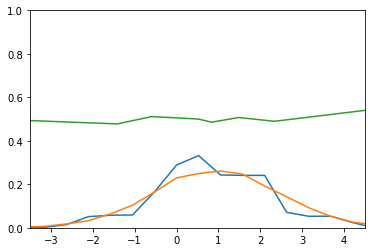

In [16]:
        noise_sample = noise.sample(num_samples)
        gen_data = G.forward(noise_sample)
        prob, _ = np.histogram(gen_data, global_bins, density=True)
        plt.plot(global_xvals, prob, label='real data')

        ## For Real Data
        data_sample = data.sample(num_samples)
        prob, _ = np.histogram(data_sample, global_bins, density=True)
        plt.plot(global_xvals, prob, label='generated data')

        ## discriminative boundary
        x_sample = np.linspace(-data_range, data_range, num_samples)
        dis_data = Dl2.forward(Dl1.forward(x_sample))
        plt.plot(x_sample, dis_data, label='decision boundary')

        maxy =  max(1, np.max(prob) * 1.1)
        plt.ylim(0,maxy)
        minx = max(mean - std * 3, -data_range * 0.9)
        miny = min(mean + std * 3, data_range * 0.9)
        plt.xlim(minx, miny)

In [17]:
gen_data.mean(), gen_data.std()

(0.8325154455945891, 1.3570060843153386)